In [1]:
# imports general modules, runs ipython magic commands
# change path in this notebook to point to repo locally
# n.b. sometimes need to run this cell twice to init the plotting paramters
%run ./setup_notebook.ipynb

In [2]:
from opto_stim_import2 import BlimpImport
import pickle
from utils.utils_funcs import d_prime
import scipy.stats as scst
sys.path.append(os.path.expanduser('/home/jrowland/mnt/qnap/Data'))
sys.path.append('/home/jrowland/mnt/qnap')

sys.path.append('..')
sys.path.append('/home/aebbeling/Vape/utils')

import seaborn as sns
from cycler import cycler

figure_path = '/home/jrowland/mnt/qnap/Figures/alek_thesis'
if not os.path.exists(figure_path):
    os.mkdir(figure_path)

In [3]:
plt.rcParams['axes.prop_cycle'] = cycler(color=sns.color_palette('colorblind'))

def save_figure(name, base_path=figure_path):
    plt.rcParams['pdf.fonttype'] = 42
    plt.savefig(os.path.join(base_path, f'{name}.pdf'), 
                bbox_inches='tight', transparent=True)


In [4]:
mice_dicts = [
    
{'mouse_id': 'J048'},
{'mouse_id': 'RL048'},
{'mouse_id': 'J063'},
{'mouse_id': 'J064'},
{'mouse_id': 'J065'},
{'mouse_id': 'RL070'},
{'mouse_id': 'RL072'},
{'mouse_id': 'RL127'},
{'mouse_id': 'RL129'},
{'mouse_id': 'RL130'},
{'mouse_id': 'RL131'},
{'mouse_id': 'RL132'},

]

mice_dicts_controls = [
    
{'mouse_id': 'J045'},
{'mouse_id': 'J046'},
{'mouse_id': 'RL037'},
{'mouse_id': 'RL038'},

]

In [5]:
for mouse_dict in mice_dicts:
    mouse_obj = BlimpImport(mouse_dict['mouse_id'])
    mouse_dict['runs'] = mouse_obj.import_1p()
    
for mouse_dict in mice_dicts_controls:
    mouse_obj = BlimpImport(mouse_dict['mouse_id'])
    mouse_dict['runs'] = mouse_obj.import_1p()

['/home/jrowland/mnt/qnap/Data/1-photon-behaviour/opto_stim_J047_J048/J048-2019-06-12-164549.txt']
Importing data file: J048-2019-06-12-164549.txt
['/home/jrowland/mnt/qnap/Data/1-photon-behaviour/opto_stim_J047_J048/J048-2019-06-13-160645.txt']
Importing data file: J048-2019-06-13-160645.txt
['/home/jrowland/mnt/qnap/Data/1-photon-behaviour/opto_stim_J047_J048/J048-2019-06-14-163539.txt']
Importing data file: J048-2019-06-14-163539.txt
['/home/jrowland/mnt/qnap/Data/1-photon-behaviour/opto_stim_RL047_RL048/RL048-2019-06-12-181929.txt']
Importing data file: RL048-2019-06-12-181929.txt
['/home/jrowland/mnt/qnap/Data/1-photon-behaviour/opto_stim_RL047_RL048/RL048-2019-06-13-172939.txt']
Importing data file: RL048-2019-06-13-172939.txt
['/home/jrowland/mnt/qnap/Data/1-photon-behaviour/opto_stim_RL047_RL048/RL048-2019-06-14-175540.txt']
Importing data file: RL048-2019-06-14-175540.txt
['/home/jrowland/mnt/qnap/Data/1-photon-behaviour/opto_stim_RL047_RL048/RL048-2019-06-16-221750.txt']
Impo

['/home/jrowland/mnt/qnap/Data/1-photon-behaviour/older/2019-06-01/Behaviour1/J046-2019-06-01-131933.txt']
Importing data file: J046-2019-06-01-131933.txt
['/home/jrowland/mnt/qnap/Data/1-photon-behaviour/older/2019-06-02/Behaviour1/J046-2019-06-02-162923.txt']
Importing data file: J046-2019-06-02-162923.txt
['/home/jrowland/mnt/qnap/Data/1-photon-behaviour/older/2019-06-03/Behaviour1/J046-2019-06-03-210644.txt']
Importing data file: J046-2019-06-03-210644.txt
['/home/jrowland/mnt/qnap/Data/1-photon-behaviour/J046-2019-06-04-144132.txt']
Importing data file: J046-2019-06-04-144132.txt
['/home/jrowland/mnt/qnap/Data/1-photon-behaviour/J046-2019-06-04-152215.txt']
Importing data file: J046-2019-06-04-152215.txt
['/home/jrowland/mnt/qnap/Data/1-photon-behaviour/older/2019-05-30/Behaviour1/RL037-2019-05-30-211454.txt']
Importing data file: RL037-2019-05-30-211454.txt
['/home/jrowland/mnt/qnap/Data/1-photon-behaviour/older/2019-05-31/Behaviour1/RL037-2019-05-31-173254.txt']
Importing data f

In [6]:
def get_power_arr(runs):
    
    powers_on_sample = [10,5,2,1,0.5,0.2,0.1]
    
    LED_currents = []
    for run in runs:
        if run.session.task_name == 'opto_stim_psychometric':
            continue
        else:
            [LED_currents.append(l) for l in run.LED_current]
    switch_trials = [i for i,d in enumerate(np.diff(LED_currents)) if d != 0] 
    
    power_arr = np.zeros(len(LED_currents)) - 100
    
    for i in range(len(switch_trials)):

        if i == 0: 
            power_arr[0:switch_trials[0]] = powers_on_sample[0]
        elif i == len(switch_trials)-1:
            power_arr[switch_trials[i]:] = powers_on_sample[-1]
        
        power_arr[switch_trials[i-1]:switch_trials[i]] = powers_on_sample[i-1]
            
    return power_arr

In [7]:
## This gives the mean where a power of 0 is awarded to mice that have completed the sessions
#change "arr = np.append(arr,[0]*(maxlen - len(arr)))" to have NaN instead of 0 for other plot

def ladder_plot(mice_dicts, color=0, label=None):
    
    power_arrs = []
    
    for mouse_dict in mice_dicts:
    
        power_arrs.append(get_power_arr(mouse_dict['runs']))

    maxlen =  max([len(a) for a in power_arrs]) 
    tomean = np.zeros((maxlen, len(power_arrs)))

    for i, arr in enumerate(power_arrs):
        arr = np.append(arr,[0]*(maxlen - len(arr)))
        tomean[:,i] = arr

    meaned = np.nanmean(tomean,1)
    
    plt.plot(meaned, color=sns.color_palette()[color], label=label)
    
    for arr in power_arrs:
        plt.plot(arr, color=sns.color_palette()[color], alpha=0.2)
        

In [8]:
from matplotlib import rcParams

params = {'legend.fontsize': 'xx-large',
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}

plt.rc("axes.spines", top=False, right=False) # despine

COLORS = [
'#228E5E', # Hit green
'#DB3713', # Miss red
]

## MAKE THE FONT SIZE 20 or 21
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
rcParams['font.size'] = 14


rcParams.update(params)

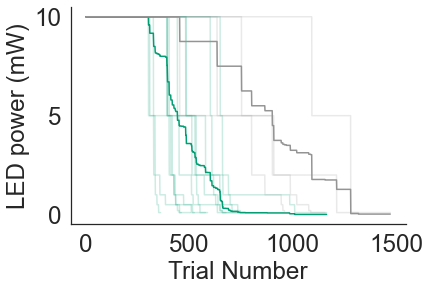

In [9]:
plt.figure()

labels = ['Opsin-expressing','Control']

ladder_plot(mice_dicts, label=labels[0], color=2)
ladder_plot(mice_dicts_controls, label=labels[1], color=7)

plt.xlabel('Trial Number')
plt.ylabel('LED power (mW)')
#plt.legend(bbox_to_anchor=(0.6, 0.8))
sns.despine()
save_figure('Ladder')


In [10]:
def get_autoswitch(mice_dicts):
       
    autoswitches = []
      
    for mouse_dict in mice_dicts: 
        autoswitch = 0
        for run in mouse_dict['runs']:
            if not run.trial_autoswitch:
                autoswitch += run.n_trials_complete
            else:
                autoswitch += run.trial_autoswitch
                break
                
        autoswitches.append(autoswitch)
                
    return autoswitches

In [11]:
def bar_plotter(data, labels, save_name, ypos, ylab = 'Trials to Criterion'):
    
    fig = plt.figure()

    mean_data = [np.nanmean(d) for d in data]
    bar_width = 0.9
    for i,d in enumerate(data):
        plt.plot([ypos[i]]*len(d), d, '.', color=sns.color_palette()[6], markersize=2)
    plt.bar(ypos, mean_data, bar_width)
    plt.xticks(ypos, labels)
    plt.ylabel(ylab)
    fig.autofmt_xdate()
    sns.despine()
    plt.savefig(os.path.join(figure_path, save_name + '.pdf'), )
    plt.savefig(os.path.join(figure_path, save_name + '.png'), bbox_inches="tight")

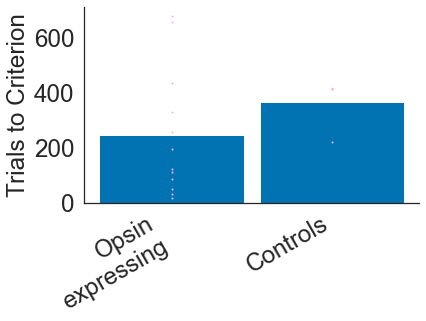

In [13]:
data = [get_autoswitch(mice_dicts), get_autoswitch(mice_dicts_controls)]
labels = ('Opsin\nexpressing', 'Controls')
palette = [sns.color_palette()[2],sns.color_palette()[7]]
save_name = 'Trials_to_criterion'
ypos = [0,1]

bar_plotter(data, labels, save_name, ypos, )

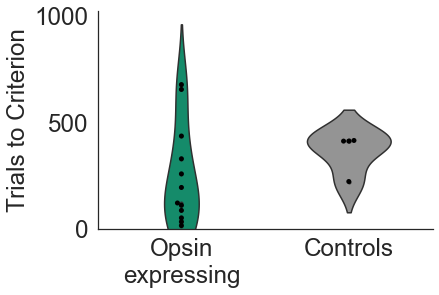

In [14]:
x = [get_autoswitch(mice_dicts), get_autoswitch(mice_dicts_controls)]
ax = sns.swarmplot(data = x, color = 'black' )
ax = sns.violinplot(data = x, inner = "point", width = 0.5, palette=palette)
ax.set_xticklabels(labels)
ax.set_ylabel('Trials to Criterion')
plt.ylim(0, None)
save_figure('Trials to cirt')

opsin expressing
247.16666666666666
222.8978964060052


In [26]:
print("opsin expressing")
print(np.mean(x[0]))
print(np.std(x[0]))
print('\n')

print('Controls')
print(np.mean(x[1]))
print(np.std(x[1]))

opsin expressing
666.8333333333334
206.1932076691395


Controls
1229.75
187.01520660096065


In [53]:
scst.mannwhitneyu(x[0], x[1])

MannwhitneyuResult(statistic=14.0, pvalue=0.12447730761863995)

In [24]:
power_arrs_control = []  
len_power_control = []

power_arrs = []
len_power = []

for mouse_dict in mice_dicts:
    power_arrs.append(get_power_arr(mouse_dict['runs']))

for i in np.arange(len(power_arrs)):
    print(len(power_arrs[i]))
    len_power.append(len(power_arrs[i]))

for mouse_dict in mice_dicts_controls:
    power_arrs_control.append(get_power_arr(mouse_dict['runs']))

for i in np.arange(len(power_arrs_control)):
    print(len(power_arrs_control[i]))
    len_power_control.append(len(power_arrs_control[i]))

525
1165
362
678
742
744
589
772
579
462
506
878
970
1473
1319
1157


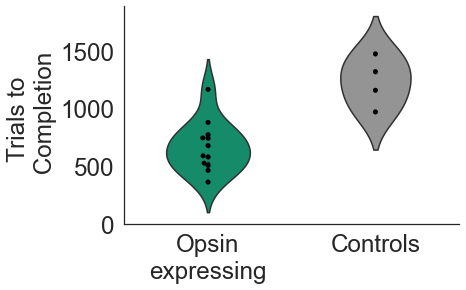

In [25]:
x = [len_power, len_power_control]
ax = sns.swarmplot(data = x, color = 'black' )
ax = sns.violinplot(data = x, inner = "point", width = 0.5, palette = palette)
ax.set_xticklabels(labels)
ax.set_ylabel('Trials to \n Completion')
plt.ylim(0, None)
save_figure('wooooooooooooooooo')

In [27]:
scst.mannwhitneyu(len_power, len_power_control)

MannwhitneyuResult(statistic=2.0, pvalue=0.004563528464786798)

In [31]:
print("opsin expressing")
print(round(np.mean(x[0]), 0))
print(round(np.std(x[0]), 0))
print('\n')

print('Controls')
print(round(np.mean(x[1]), 0))
print(round(np.std(x[1]), 0))


opsin expressing
667.0
206.0


Controls
1230.0
187.0


In [32]:
def get_dprimes(mice_dicts):
    
    dprimes = []
    for mouse_dict in mice_dicts:
        for run in mouse_dict['runs']:
            if run.session.task_name == 'opto_stim_psychometric':
                continue
            else:
                dprimes.append(run.dprime)
                
    return dprimes

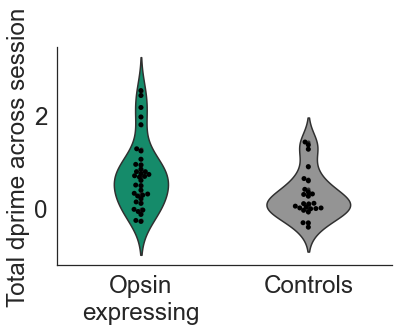

In [33]:
x = [get_dprimes(mice_dicts), get_dprimes(mice_dicts_controls)]
ax = sns.swarmplot(data = x, color = 'black')
ax = sns.violinplot(data = x, inner = "point", width = 0.5, palette=palette)
ax.set_xticklabels(labels)
ax.set_ylabel('Total dprime across session')
save_figure('Toatal-drimes')

In [37]:
print("opsin expressing")
print(round(np.mean(x[0]), 2))
print(round(np.std(x[0]), 2))
print(len(x[0]))

print('\n')

print('Controls')
print(round(np.mean(x[1]), 2))
print(round(np.std(x[1]), 2))
print(len(x[1]))



opsin expressing
0.71
0.73
35


Controls
0.28
0.49
25


In [62]:
x[0]

[0.27702447518226525,
 0.6968291979841337,
 0.49550036663870267,
 -0.029928452089894808,
 0.7846198393583335,
 0.38559724339778717,
 0.5965990867319304,
 0.3167471969740114,
 1.8016908039669954,
 2.540174673335472,
 -0.2911145395826984,
 0.7853375500603461,
 1.2356349209992983,
 2.4332938880941004,
 -0.2698664155273909,
 0.7255300776298987,
 0.9429506526903657,
 2.1740684087753595,
 -0.14034770802027619,
 0.7446224646669487,
 1.0547195160889637,
 0.13068416048052223,
 0.9301358947427525,
 -0.0446246175464573,
 0.3013122994061066,
 1.969371517674778,
 0.20120104231792824,
 0.8389576347424194,
 0.09859940233613829,
 1.2801541895558342,
 0.2593633009622256,
 0.6824585173810206,
 -0.07685855638764583,
 0.668407201989396,
 0.4836498878013362]

In [63]:
scst.mannwhitneyu(x[0], x[1])

MannwhitneyuResult(statistic=268.0, pvalue=0.00563770369010003)

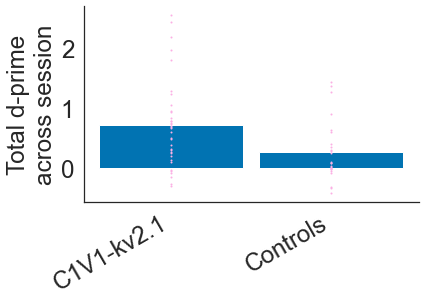

In [21]:
ypos = [0,1]

bar_plotter([get_dprimes(mice_dicts),get_dprimes(mice_dicts_controls)], labels, '1-photon-dprimes',
            ypos, ylab='Total d-prime\nacross session')



In [22]:
pm_runs = []
for mouse_dict in mice_dicts:
    for run in mouse_dict['runs']:
        if run.session.task_name == 'opto_stim_psychometric':
            pm_runs.append(run)

In [23]:
psychos = []

for idx, run in enumerate(pm_runs):
    
    LED_currents = run.LED_current
    currents = np.unique(LED_currents)

    n_fp = (run.outcome=='fp').sum()
    n_cr = (run.outcome=='cr').sum()

    go_idx = np.where((run.outcome=='hit') | (run.outcome=='miss') )[0]
    go = run.outcome[go_idx]
    
    # Hack fix to the off by one error, be careful with this
    LED_currents = LED_currents[:len(go)]

    fp_rate = n_fp / (n_fp + n_cr)
    
    dps = []
    for c in np.sort(currents):
        c_idx = np.where(LED_currents==c)

        outcome = go[c_idx]

        n_hits = (outcome=='hit').sum()
        n_miss = (outcome=='miss').sum()

        hit_rate = n_hits / (n_hits + n_miss)

        dp = d_prime(hit_rate, fp_rate)
        
        dps.append(dp)

    # This fixes that some sessions are missing the reminder power
    psychos.append(dps[:5])


psychos = np.array(psychos)



In [24]:
# x = [0.02, 0.04, 0.06, 0.08, 0.1]

# plt.plot(x, np.mean(psychos,0), color = 'black')

# for session_idx in range(psychos.shape[0]):
#     plt.scatter(x, psychos[session_idx, :], alpha=0.8, color = 'black', s = 10)
    
# ax.set_xticklabels(x)
# plt.xlabel('power (mW)')
# plt.ylabel('d prime')

# save_figure('1P-Psychometric')

In [25]:
# wes_cols = {}
# for ii, x in enumerate(plt.rcParams['axes.prop_cycle']()):
#     wes_cols[ii] = x['color']
#     if ii > 8:
#         break
        
        
# mw = x
# meaned = np.mean(psychos,0)
# plt.plot(mw, meaned,  linewidth=5, linestyle='-', 
#         markersize=15, color=wes_cols[2], label=None, alpha=1)



# for i in range(psychos.shape[0]):
#     plt.plot(mw, psychos[i,:], '.', markersize=15, alpha=0.7, color='grey')
# plt.xlabel('power (mW)')
# plt.ylabel('d prime')
# plt.savefig(os.path.join(figure_path, '1-photon_dps.pdf'),
#             transparent=True, bbox_inches='tight')

In [36]:
from scipy.optimize import curve_fit

# psychometric function
def pf(x, max_value, alpha, beta):
    ''' Max value: max value of sigmoid
        alpha: x_axis midpoint
        beta: the growth rate
    '''
    return max_value / (1 + np.exp( -(x-alpha)/beta))

x = [0.02, 0.04, 0.06, 0.08, 0.1]

alpha = 0.04
beta = 0.05

dp = np.ravel(psychos)

x_axis = x * psychos.shape[0]

popt, pcov = curve_fit(pf, x_axis, dp, method = 'dogbox', p0=[max(dp), alpha, beta])

In [35]:
# Find the midpoint empirally as cba to invert the function
mid_dp = popt[0] / 2
search = np.linspace(0.05, 0.075, 1001)

min_error = 100000
best = None
for val in search:
    error = abs(mid_dp - pf(val, *popt))
    
    if error < min_error:
        best = val
        min_error = error
        
midpoint = round(best, 4)
f'Psychometric midpoint = {midpoint}'

'Psychometric midpoint = 0.0603'

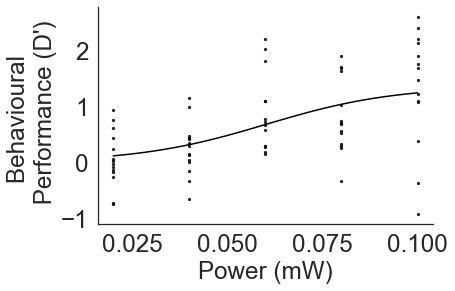

In [37]:

plt.plot(np.linspace(min(x_axis), max(x_axis),100), pf(np.linspace(min(x_axis), max(x_axis),100), *popt), color='black')
    
for session_idx in range(psychos.shape[0]):
    plt.scatter(x, psychos[session_idx, :], alpha=0.8, color = 'black', s = 5)

plt.xlabel('Power (mW)')
plt.ylabel("Behavioural \n Performance (D')")

save_figure('1P-Psychometric_fitted')

In [ ]:
# for run in pm_runs:
#     binned_licks = np.array(run.binned_licks)

#     trial_type = np.array(run.trial_type)
#     tt_inds = trial_type.argsort(kind='mergesort')

#     sorted_licks = binned_licks[tt_inds]

#     num_go = len(np.where(trial_type=='go')[0])


#     for i,b in enumerate(sorted_licks):
#         y_axis = np.ones(len(b)) + (i) 
#         if i < num_go:
#             color = 'black'
#         else:
#             color = 'red'
#         plt.plot(b/1000, y_axis,'.',c=color)
#     print(str(run))
#     plt.xlim(-1,4)
#     plt.show()

In [ ]:
#Select runs

pm_runs = []
for mouse_dict in mice_dicts:
    for run in mouse_dict['runs']:
        if run.session.task_name == 'opto_stim':
            pm_runs.append(run)

            
#Plot all-licks raster

run = pm_runs[11] #A good example session
binned_licks = np.array(run.binned_licks)

trial_type = np.array(run.trial_type)
tt_inds = trial_type.argsort(kind='mergesort')

sorted_licks = binned_licks[tt_inds]

num_go = len(np.where(trial_type=='go')[0])
reaction_time = []
for i,b in enumerate(sorted_licks):
    if len(b)>0:
        b = b[0]
        if i < num_go:
            color = 'black'
        else:
            color = 'red'
        reaction_time.append(b)
        plt.plot(b/1000, i,'.',c=color)
plt.xlim(-0.05,2)
plt.yticks([])
plt.xlabel('Time (s)')
plt.ylabel('Trials')

save_figure('First_Lick_Raster')

#Trying to make it plot the first value only, but the problem is that you cant take
#the first value of an empty array 

In [ ]:
#Select runs

pm_runs = []
for mouse_dict in mice_dicts:
    for run in mouse_dict['runs']:
        if run.session.task_name == 'opto_stim':
            pm_runs.append(run)

            
#Plot all-licks raster

run = pm_runs[11] #A good example session
binned_licks = np.array(run.binned_licks)

trial_type = np.array(run.trial_type)
tt_inds = trial_type.argsort(kind='mergesort')

sorted_licks = binned_licks[tt_inds]

num_go = len(np.where(trial_type=='go')[0])
reaction_time = []
for i,b in enumerate(sorted_licks):
    if len(b)>0:
        b = b[0]
        if i < num_go:
            color = 'black'
        else:
            color = 'red'
        reaction_time.append(b)
        plt.plot(b/1000, i,'.',c=color)
plt.xlim(-0.05,2)
plt.yticks([])
plt.xlabel('Time (s)')
plt.ylabel('Trials')

save_figure('First_Lick_Raster')

#Trying to make it plot the first value only, but the problem is that you cant take
#the first value of an empty array 

In [ ]:
#Select runs

pm_runs = []
for mouse_dict in mice_dicts_controls:
    for run in mouse_dict['runs']:
        if run.session.task_name == 'opto_stim':
            pm_runs.append(run)

            
#Plot all-licks raster
ii=2
run = pm_runs[4] #A good example session
binned_licks = np.array(run.binned_licks)

trial_type = np.array(run.trial_type)
tt_inds = trial_type.argsort(kind='mergesort')

sorted_licks = binned_licks[tt_inds]

num_go = len(np.where(trial_type=='go')[0])
reaction_time = []
for i,b in enumerate(sorted_licks):
    if len(b)>0:
        b = b[0]
        if i < num_go:
            color = 'black'
        else:
            color = 'dodgerblue'
        reaction_time.append(b)
        plt.plot(b/1000, i,'.',c=color)
plt.xlim(-0.05,2)
plt.yticks([])
plt.xlabel('Time (s)')
plt.ylabel('Trials')

save_figure('First_Lick_Raster_Control')

#Trying to make it plot the first value only, but the problem is that you cant take
#the first value of an empty array

In [ ]:
reaction_times = []
    for i, rast in enumerate(sorted_licks):

        color=subset_colors[i]
        y_axis = np.ones(len(rast)) + i

        if sorted_subsets[i] != sorted_subsets[i-1] and i != 0:
            ax0.axhline(y=i, ls='--', color='black')
            line_pos.append(i)
        try:
            point = rast[0] / 1000
            if point <= 1:
                marker = '.'
                fillstyle = 'full'
            else:
                marker = '.'
                fillstyle = 'none'
            ax0.plot(point, y_axis[0], marker=marker,
                     fillstyle=fillstyle, c=color, markersize=12)
            reaction_times.append(rast[0])
        except IndexError:
            reaction_times.append(np.nan)
            pass